# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.constants import c, elementary_charge
import pandas as pd
import pickle as pkl
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [24,16] # bigger figures
from matplotlib import style
style.use('fivethirtyeight')

In [3]:
# import package
# installed via pip
from emtracks.particle import trajectory_solver # main solver object
from emtracks.conversions import one_gev_c2_to_kg # conversion for q factor (transverse momentum estimate)
from emtracks.tools import *#InitConds # initial conditions namedtuple
from emtracks.mapinterp import get_df_interp_func  # factory function for creating Mu2e DS interpolation function
from emtracks.Bdist import get_B_df_distorted
import matplotlib.animation as animation

ERROR! Please set $EMTRACKS_DDIR and $EMTRACKS_PDIR. Setting defaults (current directory)


### Directories

In [4]:
testdir = "/home/darren/Desktop/plots/"
datadir = "/home/shared_data/"
plotdir = datadir+"plots/randomphi/"
mapdir = datadir+"Bmaps/"
date = "/6-18/"

### Some global initial parameters for B dist

In [5]:
#DO NOT CHANGE ON THIS DOCUMENT
start_point = 3
end_point = 14
initial_B = 50 #(rougly 1% distortion at z = 3.0, 0% at z = 14)
final_B = 0

### Define Distorted B Field

In [6]:
#MU2E FIELD
df_Mu2e = pd.read_pickle(mapdir+"Mu2e_DSMap_V13.p")
B_Mu2e_func = get_df_interp_func(mapdir+"Mu2e_DSMap_V13.p", gauss=False)

#MU2E FIELD + DIS
df_Mu2e_dis = get_B_df_distorted(df_Mu2e, v="0", Bz0 = initial_B, Bzf = 0, z0 = start_point, zf = end_point)
B_Mu2e_dis = get_df_interp_func(df=df_Mu2e_dis, gauss=False)

### Simple Visualize B Field

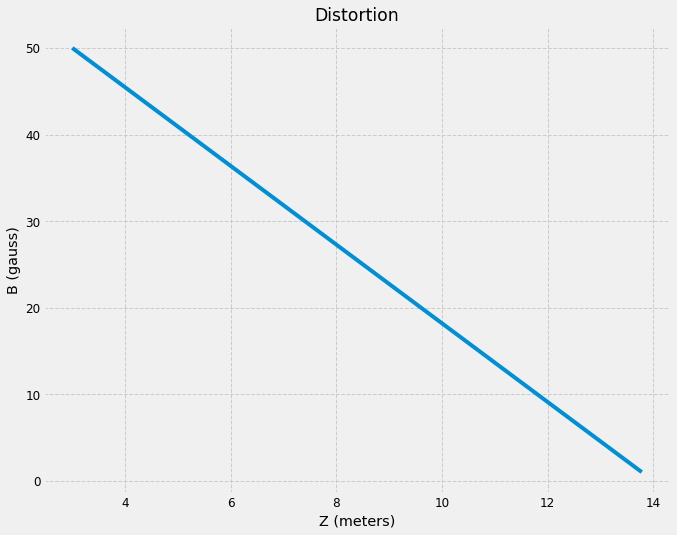

In [7]:
m = (final_B - initial_B) / (end_point - start_point)
n = 50
step = (end_point - start_point) / n
t = np.arange(start_point, end_point, step)
x = plt.plot(t, ((t - start_point)*m) + initial_B)
plt.title("Distortion")
plt.xlabel("Z (meters)")
plt.ylabel("B (gauss)")
plt.savefig(testdir+'hello1')

# Functions

In [8]:
#input N, return N random values between 0 and 2pi
def get_random_phi(N):
    phis = np.random.uniform(0, 2*math.pi, N)
    return phis

In [9]:
#input N, return N equally spaced values between 0 and 2pi
def get_uniform_phi(N):
    phis = np.linspace(0, 2*math.pi, N)
    return phis

In [10]:
#input list of phis, number of steps for integrator, initial position / return dataframe trajectory
def run_solver(phi, N_calc, field, xnaught, ynaught, znaught):
    ic_Mu2e = InitConds(t0=0., tf=4e-8, N_t=N_calc,
                    x0=xnaught, y0=ynaught, z0=znaught,
                    p0=104.96, theta0=np.pi/3, phi0=phi)
    e_solver = trajectory_solver(ic_Mu2e, B_func=field, bounds=bounds_Mu2e)
    sol = e_solver.solve_trajectory(verbose = False, atol=1e-10, rtol=1e-10) # high tolerance so it runs quickly for testing
    df = e_solver.dataframe
    df['r'] = ((df['x'])**2 + (df['y'])**2)**(1/2)
    #df['r'] = ((df['x']-xnaught)**2 + (df['y']-ynaught)**2)**(1/2)
    return df

In [11]:
#input previous dataframe of trajectory, any z value / return new dataframe with x, y, z, t, r values at a z
def find_track_at_z(df, z): 
    delta = 10/4001   #approximate z range divided by number of points
    mask = (df.z < z + delta) & (df.z > z - delta)
    
    while (len(df.z[mask]) > 2):
        delta = delta / 2
        mask = (df.z < z + delta) & (df.z > z - delta)
    while (len(df.z[mask]) == 0):
        delta = delta*2
        mask = (df.z < z + delta) & (df.z > z - delta)
       
    df2 = df.loc[mask]
    df2 = df2.apply(pd.to_numeric)
    return (df2.iloc[0]['x'], df2.iloc[0]['y'], df2.iloc[0]['z'], df2.iloc[0]['t'], df2.iloc[0]['r'])

In [12]:
def plot_impact_at_calorimeter(info, output_directory): #ts, phis, rs, xs, ys, zs
    ts = info[0]
    phis = info[1]
    rs = info[2]
    xs = info[3]
    ys = info[4]
    zs = info[5]
    
    fig = plt.figure()
    plt.scatter(xs, ys, c = phis)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Y as a fn of X")
    max_coord = 1.25*np.max(abs(np.array([xs,ys])))
    plt.xlim(-max_coord, max_coord)
    plt.ylim(-max_coord, max_coord)
    #fig.savefig(plotdir+output_directory+"Scatter_y_vs_x.pdf")
    #fig.savefig(plotdir+output_directory+"Scatter_y_vs_x.png")
    
    fig2 = plt.figure()
    plt.scatter(phis, xs)
    plt.xlabel("phi_values (rad)")
    plt.ylabel("x coordinate")
    plt.title("X as a fn of phi")
    #fig2.savefig(plotdir+output_directory+"Scatter_x_vs_phi.pdf")
    #fig2.savefig(plotdir+output_directory+"Scatter_x_vs_phi.png")
    
    fig3 = plt.figure()
    plt.scatter(phis, ys)
    plt.xlabel("phi_values (rad)")
    plt.ylabel("y coordinate")
    plt.title("Y as a fn of phi")
    #fig3.savefig(plotdir+output_directory+"Scatter_y_vs_phi.pdf")
    #fig3.savefig(plotdir+output_directory+"Scatter_y_vs_phi.png")

    fig4 = plt.figure()
    x = xs
    num_bins = 50
    n, bins, patches = plt.hist(x, num_bins, facecolor='blue')
    plt.xlabel('xcoord')
    plt.ylabel('number of occurences')
    plt.title('Histogram of x-coord')
    #fig4.savefig(plotdir+output_directory+"Histogram_x.pdf")
    #fig4.savefig(plotdir+output_directory+"Histogram_x.png")
    
    fig5 = plt.figure()
    y = ys
    num_bins = 50
    n, bins, patches = plt.hist(y, num_bins, facecolor='blue')
    plt.xlabel('ycoord')
    plt.ylabel('number of occurences')
    plt.title('Histogram of y-coord')
    #fig5.savefig(plotdir+output_directory+"Histogram_y.pdf")
    #fig5.savefig(plotdir+output_directory+"Histogram_y.png")
    
    fig6 = plt.figure()
    r = rs
    num_bins = 50
    n, bins, patches = plt.hist(r, num_bins, facecolor='blue')
    plt.xlabel('radius')
    plt.ylabel('number of occurences')
    plt.title('Histogram of R')
    #fig6.savefig(plotdir+output_directory+"Histogram_R.pdf")
    #fig6.savefig(plotdir+output_directory+"Histogram_R.png")
    
    actualrad = ((((max(xs) - min(xs)) / 2) + ((max(ys) - min(ys)) / 2)) / 2)
    print ('actual radius: ' + str(actualrad))

In [13]:
def plotjoint(info, infograded):
    #plt.hist(data, bins=range(min(data), max(data) + binwidth, binwidth))
    
    x, y = info, infograded
    x1, x2 = x[2], y[2]
    num_bins = 20

    m1 = np.mean(x1)
    std1 = np.std(x1)
    m2 = np.mean(x2)
    std2 = np.std(x2)
    x1num_bins = int((max(x1) - min(x1)) / 0.005)
    x2num_bins = int((max(x2) - min(x2)) / 0.005)
    

    fig1 = plt.figure()
    
    plt.hist(x1, alpha = 0.3, bins = x1num_bins, facecolor='blue', label = 'Mu2e Field')
    plt.hist(x2, alpha = 0.8, bins = x2num_bins, facecolor='orange', label = 'Graded Field')

    plt.legend()
    plt.legend()

    #plt.text(0.3, 21, '\u03BC = '+str(round(np.mean(x1), 5)), fontsize = 8)
    #plt.text(0.3, 20.6, '\u03C3 = '+str(round(np.std(x1), 5)), fontsize = 8)
    #plt.text(0.3, 20.2, '\u03BC graded = '+str(round(np.mean(x2), 5)), fontsize = 8)
    #plt.text(0.3, 19.8, '\u03C3 graded = '+str(round(np.std(x2), 5)), fontsize = 8)

    plt.xlabel('Radius (meters)')
    plt.ylabel('Occurences')
    plt.title('Histogram of Radius At Z=13 Meters, varying initial phi')  
    fig1.show
    #fig1.savefig(testdir)
    #fig1.savefig(plotdir+output_directory+"6-11/2Graded_radiushist500.pdf")
    #fig1.savefig(plotdir+output_directory+"6-11-2Graded_radiushist.png")
    fig1.savefig(plotdir+date+"1")

    #---------------
    x1, x2 = x[3], y[3]
    num_bins = 20
    m1 = np.mean(x1)
    std1 = np.std(x1)
    m2 = np.mean(x2)
    std2 = np.std(x2)

    fig2 = plt.figure()

    plt.hist(x1, alpha = 0.3, bins = num_bins, facecolor='blue',  label = 'normal')
    plt.hist(x2, alpha = 0.8, bins = num_bins, facecolor='orange',  label = 'graded')

    plt.legend()

    #plt.text(0.2, 17, '\u03BC = '+str(round(np.mean(x1), 5)), fontsize = 8)
    #plt.text(0.2, 16.5, '\u03C3 = '+str(round(np.std(x1), 5)), fontsize = 8)
    #plt.text(0.2, 16, '\u03BC graded = '+str(round(np.mean(x2), 5)), fontsize = 8)
    #plt.text(0.2, 15.5, '\u03C3 graded = '+str(round(np.std(x2), 5)), fontsize = 8)

    plt.xlabel('X (meters)')
    plt.ylabel('Occurences')
    plt.title('Histogram of X at Z=13 Meters, varying initial phi')  
    fig2.show
    #fig2.savefig(testdir)
    #fig2.savefig(plotdir+output_directory+"6-11/2Graded_xhist500.pdf")
    #fig2.savefig(plotdir+output_directory+"6-11-2Graded_xhist.pdf")
    fig2.savefig(plotdir+date+"2")


    #-----

    x1, x2 = x[4], y[4]
    num_bins = 20
    m1 = np.mean(x1)
    std1 = np.std(x1)
    m2 = np.mean(x2)
    std2 = np.std(x2)

    fig3 = plt.figure()

    plt.hist(x1, alpha = 0.3, bins = num_bins, facecolor='blue',  label = 'normal')
    plt.hist(x2, alpha = 0.8, bins = num_bins, facecolor='orange',  label = 'graded')

    plt.legend()

    #plt.text(0.2, 16.5, '\u03BC = '+str(round(np.mean(x1), 5)), fontsize = 8)
    #plt.text(0.2, 16, '\u03C3 = '+str(round(np.std(x1), 5)), fontsize = 8)
    #plt.text(0.2, 15.5, '\u03BC graded = '+str(round(np.mean(x2), 5)), fontsize = 8)
    #plt.text(0.2, 15, '\u03C3 graded = '+str(round(np.std(x2), 5)), fontsize = 8)

    plt.xlabel('Y (meters)')
    plt.ylabel('Occurences')
    plt.title('Histogram of Y at Z=13, varying initial phi')  
    fig3.show
    #fig3.savefig(testdir)
    #fig3.savefig(plotdir+output_directory+"6-11/2Graded_yhist500.pdf")
    #fig3.savefig(plotdir+output_directory+"6-11-2Graded_yhist.pdf")
    fig3.savefig(plotdir+date+"3")
    
    return x, y

In [14]:
def plot_joint_not_hist(x, y): #(ts, phis, rs, xs, ys, zs)
    phis = x[1]
    xs = x[2]
    ys = y[2]

    fig1 = plt.figure()
    plt.scatter(phis, xs, c=x[0], marker='s', label='reg')
    plt.scatter(phis, ys, c=x[0], marker='o', label ='dis')
    plt.legend(loc='upper right')
    plt.xlabel("phis")
    plt.ylabel("radius (meters)")
    plt.title("Radius in Nominal and Graded fields at z=13 with varying initial phi")
    plt.show()
    fig1.savefig(plotdir+date+"4")

    dev = y[2]-x[2]
    fig2 = plt.figure()
    plt.scatter(phis, dev, c=x[0])
    plt.xlabel("phis")
    plt.ylabel("r")
    plt.title("R disp as a fn of phi between nom and graded fields at z=13")
    plt.show()
    fig2.savefig(plotdir+date+"6")

## First Run Function (No Graded Field)

In [15]:
def run(N, z): #
    phis = get_uniform_phi(N)
    ts = []
    xs = []
    ys = []
    zs = []
    rs = []
    # for each phi, run create solver object and save trajectory object
    for phi in phis:
        dataframe = run_solver(phi, 20001, B_Mu2e_func, 0.054094482, 0.03873037, 5.988900879) #second argument is how many steps in numerical integration
        x, y, z, t, r = find_track_at_z(dataframe,z)  
        ts.append(t)
        xs.append(x)
        ys.append(y)
        zs.append(z)
        rs.append(r)
    # convert everything to numpy arrays
    ts = np.array(ts)
    xs = np.array(xs)
    ys = np.array(ys)
    zs = np.array(zs)
    rs = np.array(rs)
    return (ts, phis, rs, xs, ys, zs)

## Second Run Function (Graded Field)

In [16]:
def run2(N, z):
    phis = get_uniform_phi(N)
    ts = []
    xs = []
    ys = []
    zs = []
    rs = []
    # for each phi, run create solver object and save trajectory object
    for phi in phis:
        dataframe = run_solver(phi, 20001, B_Mu2e_dis, 0.054094482, 0.03873037, 5.988900879) #second argument is how many steps in numerical integration
        x, y, z, t, r = find_track_at_z(dataframe,z)
        ts.append(t)
        xs.append(x)
        ys.append(y)
        zs.append(z)
        rs.append(r)
    # convert everything to numpy arrays
    ts = np.array(ts)
    xs = np.array(xs)
    ys = np.array(ys)
    zs = np.array(zs)
    rs = np.array(rs)
    # plot results (and save plots)
    return (ts, phis, rs, xs, ys, zs)
    

In [17]:
x = run(15, 13)
y = run2(15, 13)


In [19]:
x

(array([3.5628e-08, 3.5584e-08, 3.5536e-08, 3.5492e-08, 3.5450e-08,
        3.5412e-08, 3.5382e-08, 3.5368e-08, 3.5380e-08, 3.5424e-08,
        3.5498e-08, 3.5576e-08, 3.5632e-08, 3.5646e-08, 3.5622e-08]),
 array([0.        , 0.44879895, 0.8975979 , 1.34639685, 1.7951958 ,
        2.24399475, 2.6927937 , 3.14159265, 3.5903916 , 4.03919055,
        4.48798951, 4.93678846, 5.38558741, 5.83438636, 6.28318531]),
 array([0.46639421, 0.4465584 , 0.41683877, 0.38068093, 0.34199945,
        0.30676252, 0.28263854, 0.2778308 , 0.29653739, 0.33505957,
        0.38374894, 0.42885817, 0.45992236, 0.47171074, 0.46560256]),
 array([ 0.3178425 ,  0.16926661,  0.00820032, -0.13799862, -0.24411303,
        -0.29258195, -0.27584358, -0.19648014, -0.06480634,  0.10126246,
         0.27232066,  0.40433144,  0.4587956 ,  0.42411871,  0.31805228]),
 array([ 0.34132053,  0.41323507,  0.4167581 ,  0.35478776,  0.23952548,
         0.09219029, -0.06160245, -0.19643194, -0.28936924, -0.31939135,
        -0.2703

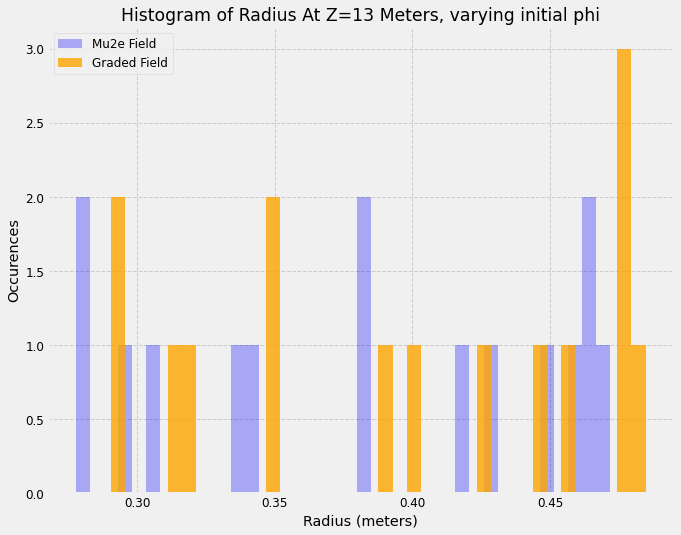

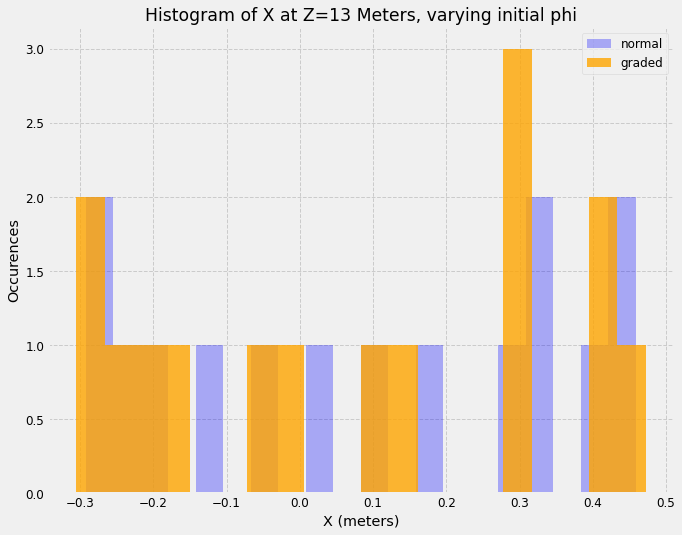

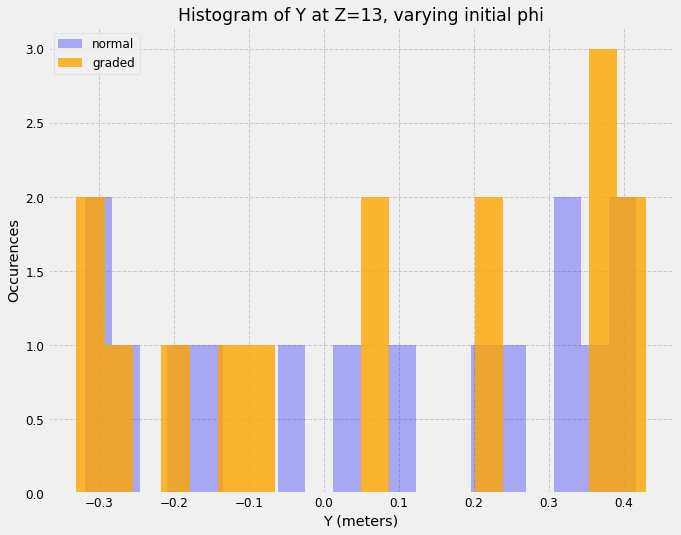

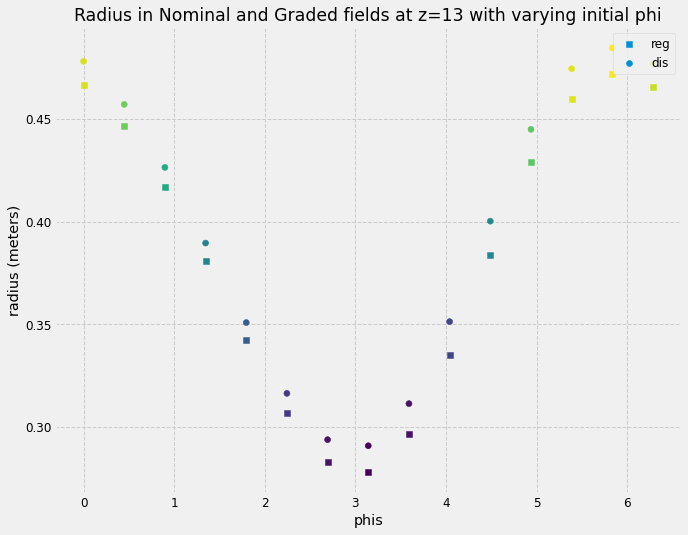

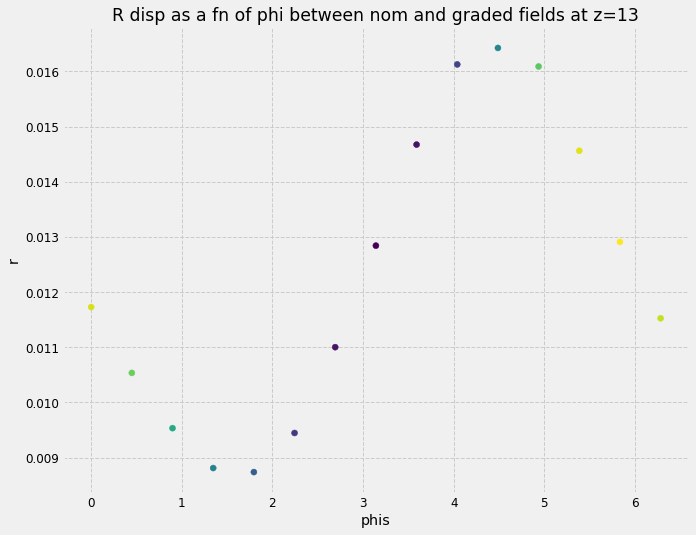

In [18]:
plotjoint(x, y)
plot_joint_not_hist(x, y) #make a histogram for this

actual radius: 0.37134452782181554
actual radius: 0.38364768128953486


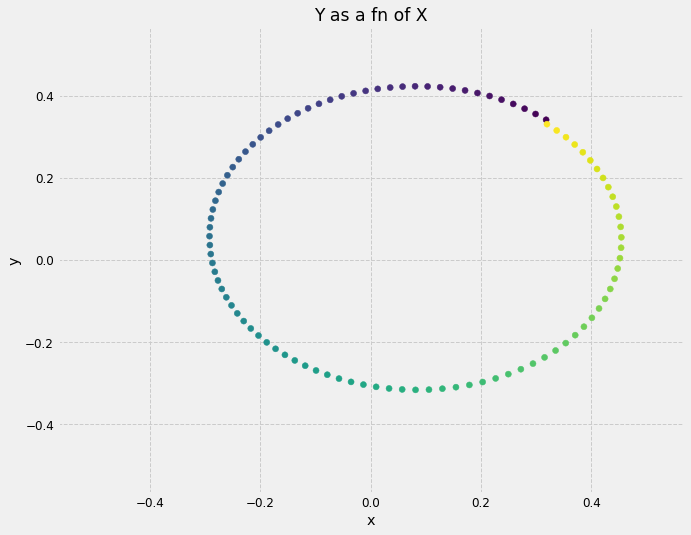

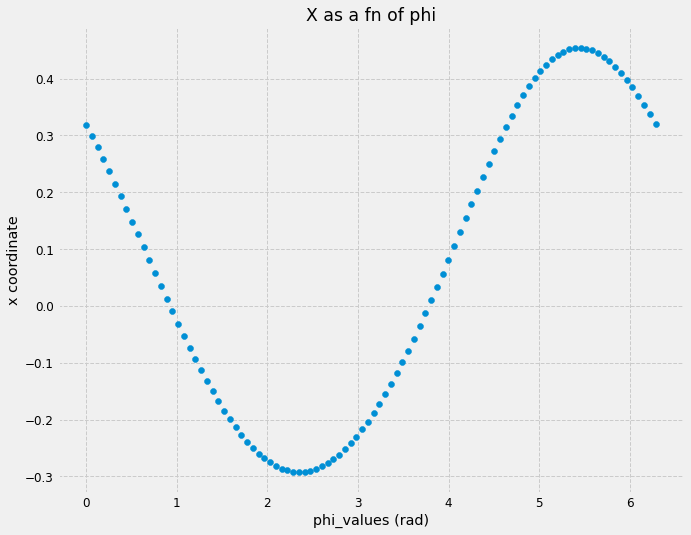

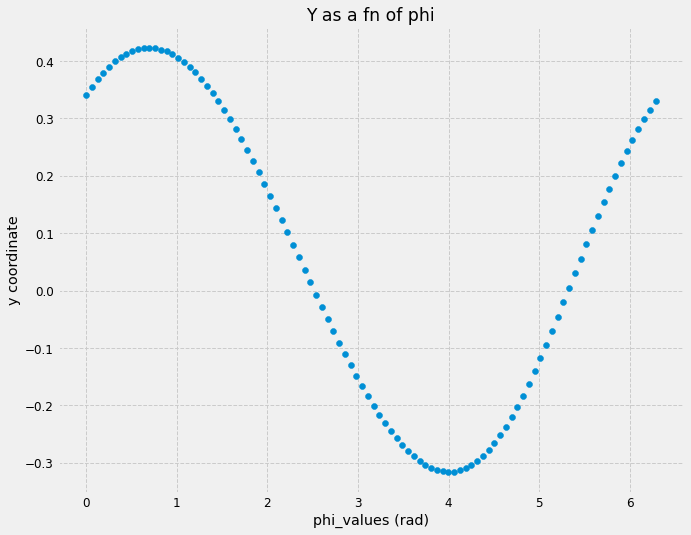

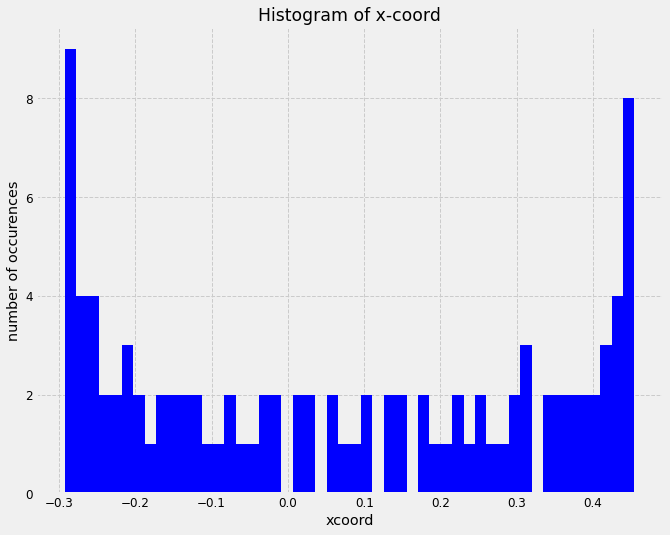

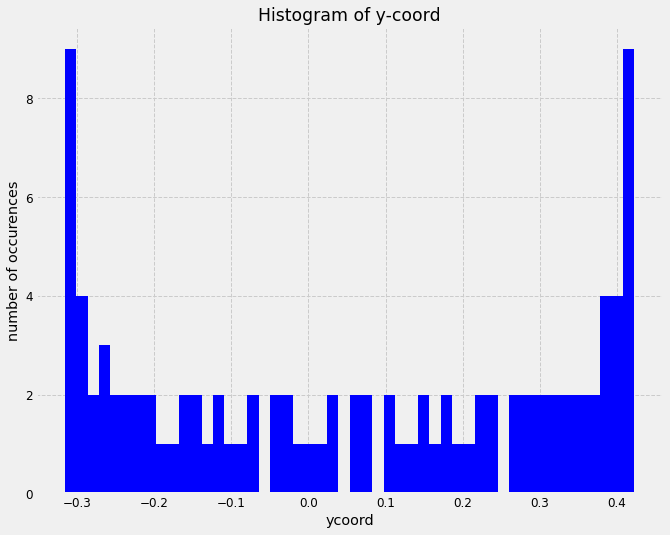

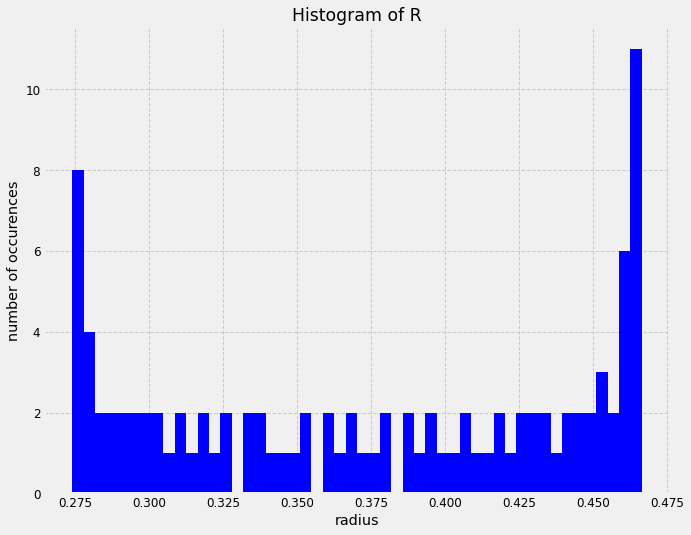

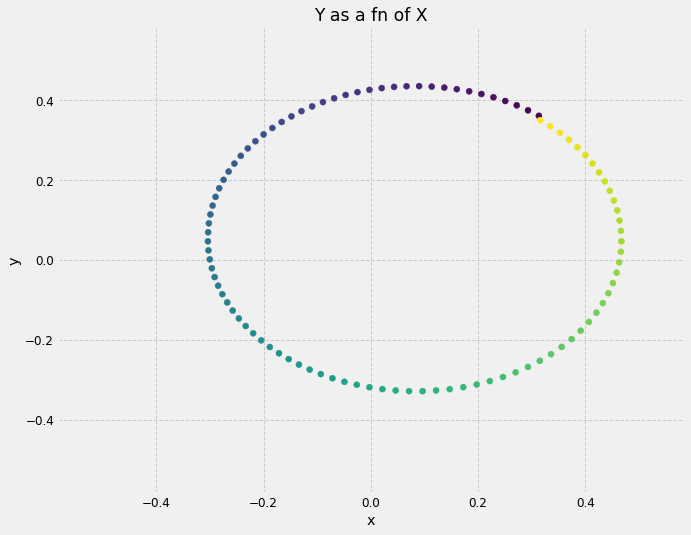

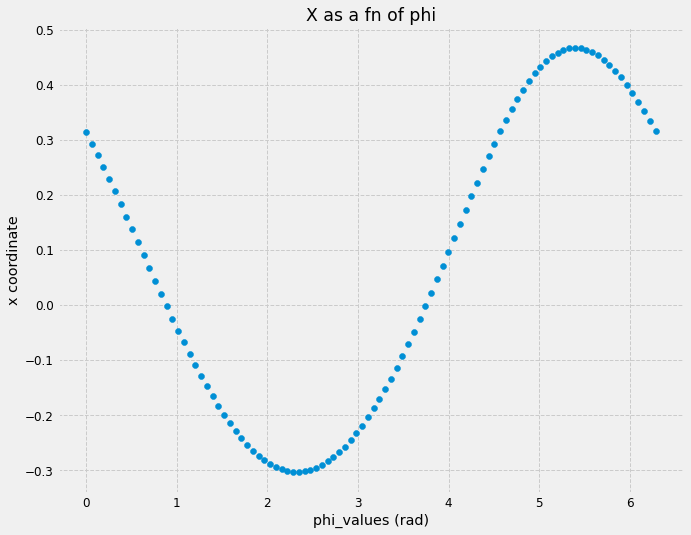

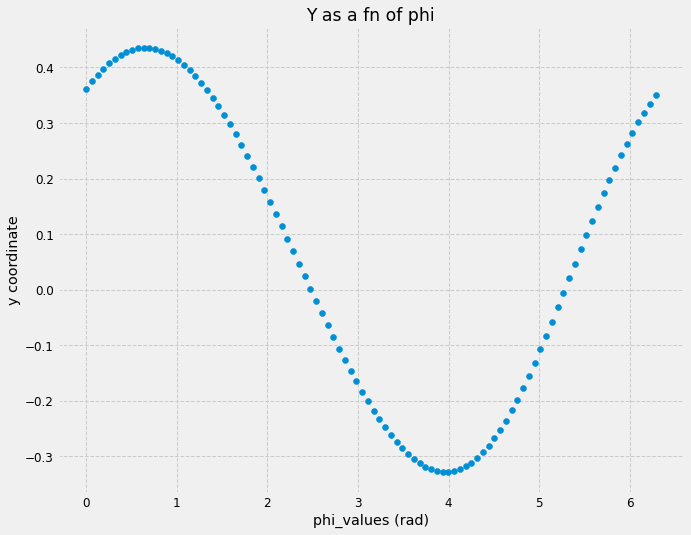

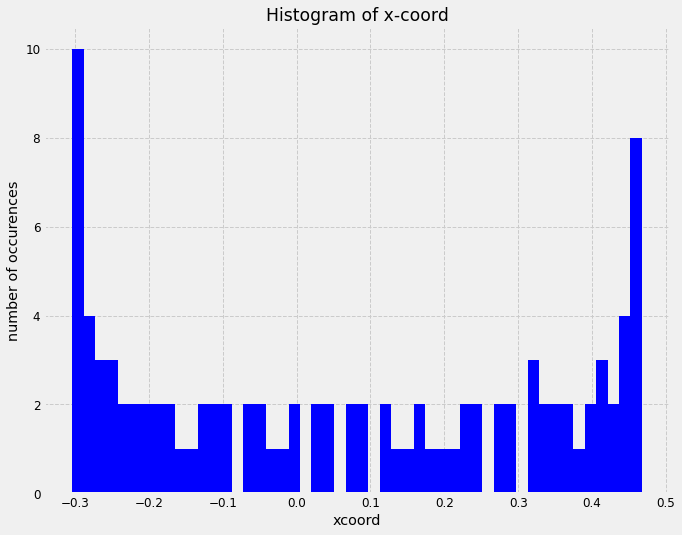

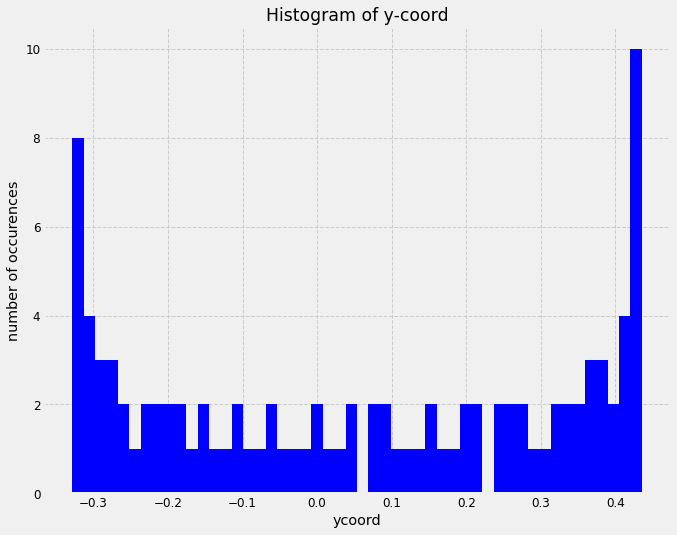

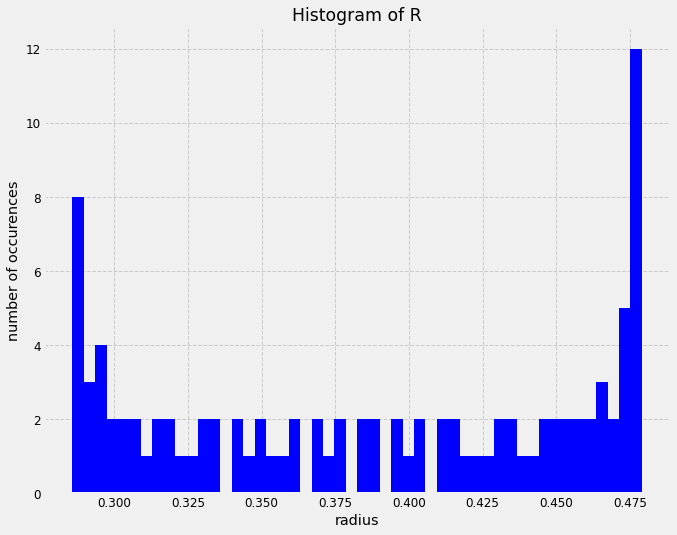

In [19]:
plot_impact_at_calorimeter(x, "run1/")
plot_impact_at_calorimeter(y, "run2/")

In [20]:
def hi(zstart, zend, numsteps, N):   #rmax, rmin, xmax, xmin, ymax, ymin
    step = (zend-zstart) / numsteps
    q = np.arange(zstart, zend+step, step)
    
    regdata = []
    gradeddata = []
    
    for i in q:
        e = run(N, i)
        f = run2(N, i)
        
        regdata.append(e)
        gradeddata.append(f)
        print(i)
        #numstep*2 numpy arrays stored, numstep in regdata, numstep in gradeddata   
        
    return regdata, gradeddata

In [1]:
t = hi(6, 13, 7, 100)


NameError: name 'hi' is not defined

In [22]:
def get_info(x, y):
    phis = x[1]
    rs1 = x[2]
    rs2 = y[2]
    xs1 = x[3]
    xs2 = y[3]
    ys1 = x[4]
    ys2 = y[4]
    
    a1 = (rs2 - rs1)
    b1 = (xs2 - xs1)
    c1 = (ys2 - ys1)
    
    return (a1, b1, c1)

In [23]:
get_info(x, y) #rmax, rmin, xmax, xmin, ymax, ymin

(array([0.01172815, 0.0116223 , 0.01151645, 0.01116893, 0.01082591,
        0.01048758, 0.0104047 , 0.01007341, 0.00999646, 0.00992177,
        0.00984992, 0.00978134, 0.00971663, 0.00965617, 0.00935997,
        0.00931014, 0.00902843, 0.00875381, 0.00848737, 0.00822919,
        0.00820319, 0.00796104, 0.00795003, 0.00794764, 0.00795396,
        0.0079692 , 0.00799423, 0.00802914, 0.00807491, 0.00813104,
        0.00819759, 0.00827615, 0.00836617, 0.00846913, 0.00858254,
        0.00870851, 0.00884672, 0.00924834, 0.00967006, 0.00984264,
        0.01002544, 0.01021791, 0.0104184 , 0.01062521, 0.01083735,
        0.01134375, 0.01155945, 0.01177527, 0.01198881, 0.01250868,
        0.01271044, 0.01290478, 0.01309065, 0.01359307, 0.0137542 ,
        0.01390332, 0.0143771 , 0.01449619, 0.01460044, 0.01503556,
        0.01510649, 0.01550865, 0.01589862, 0.01592181, 0.01593223,
        0.01627293, 0.01624696, 0.01620764, 0.01615786, 0.01643388,
        0.01669679, 0.01659679, 0.01648399, 0.01

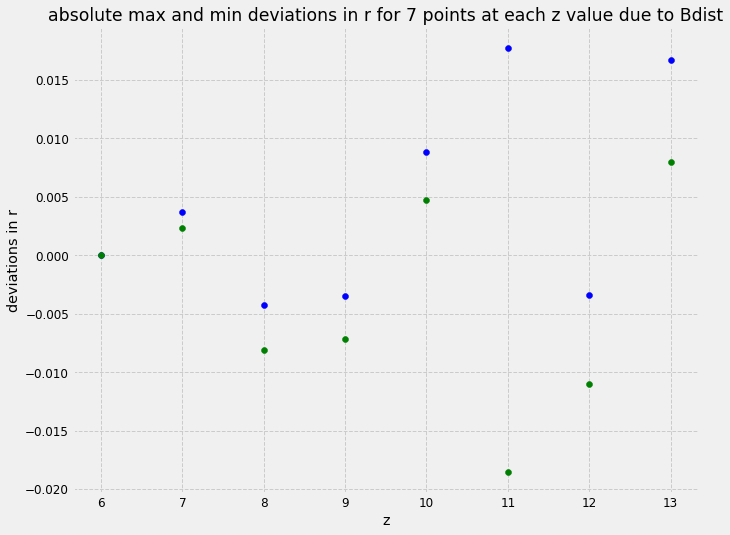

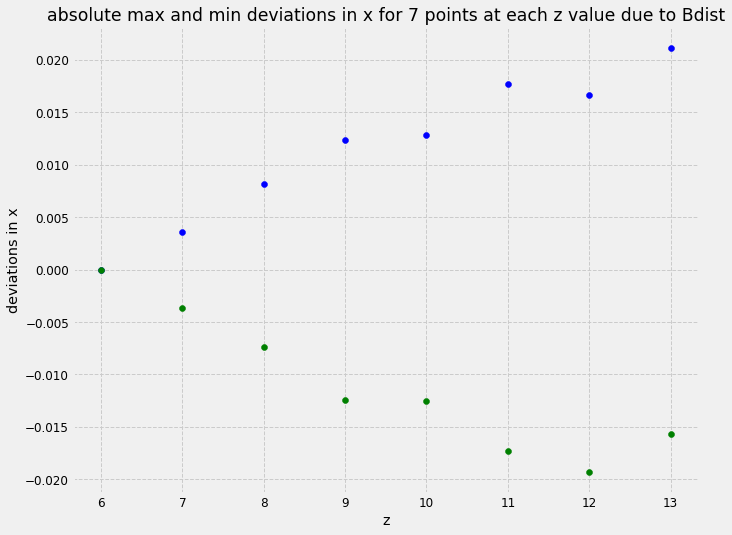

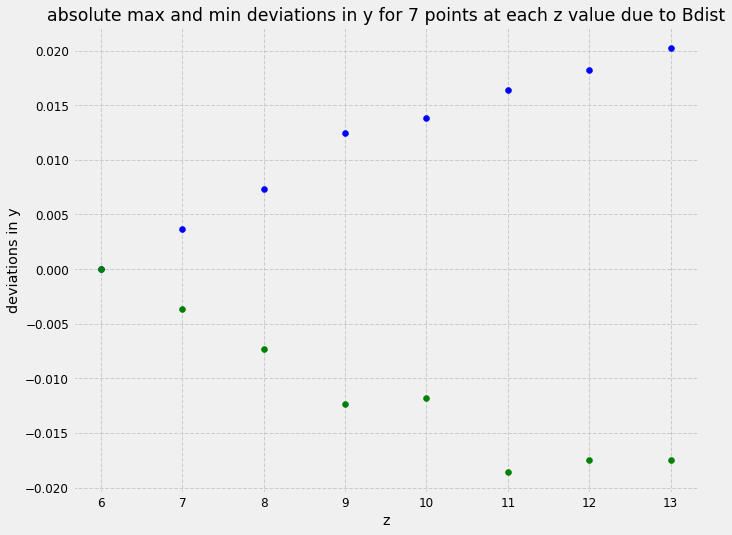

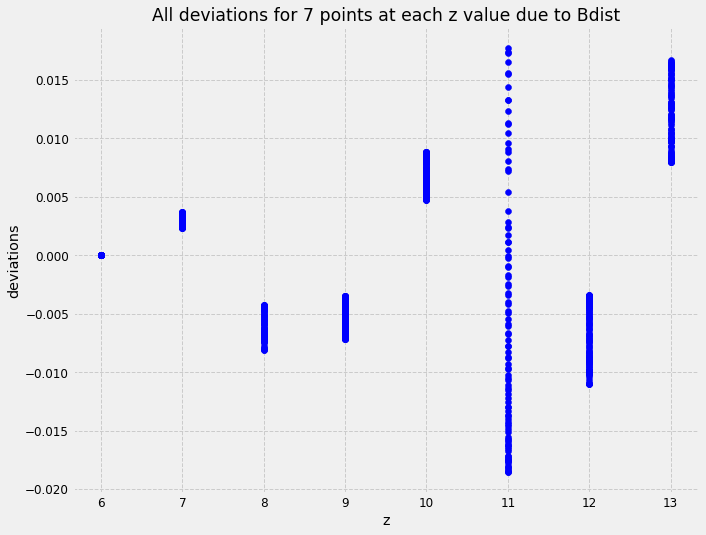

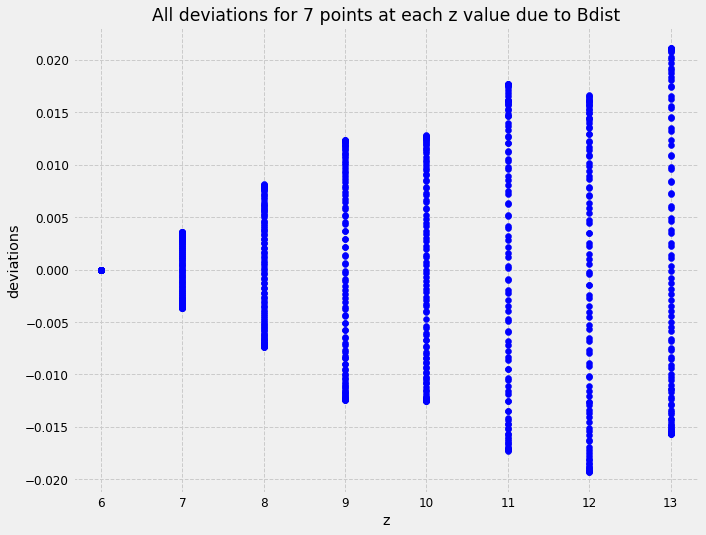

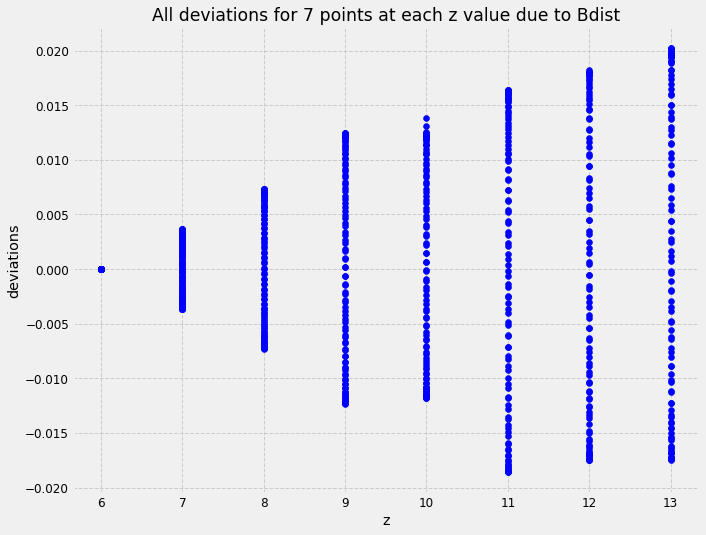

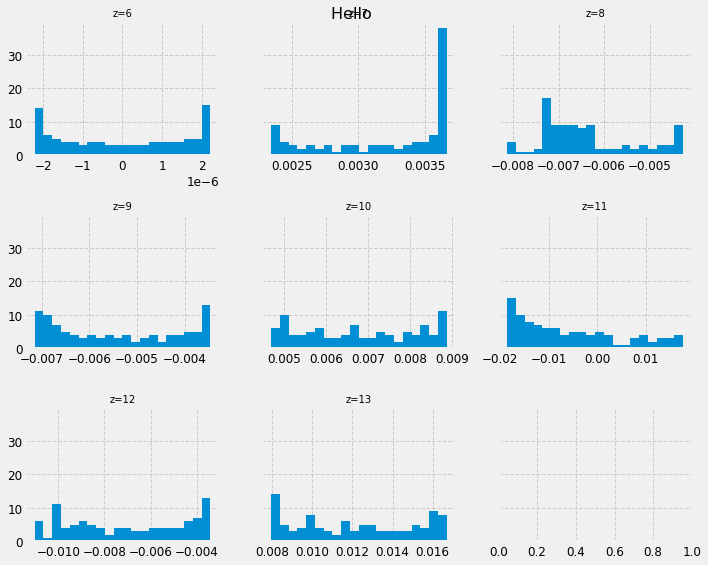

In [24]:
#call get_info
def plothi(t, zstart, zend, numsteps, N):
    step = int(((zend-zstart) / numsteps))
    a = np.linspace(zstart, zend, numsteps+1)
    
    j = []
    k = []
    l = []
   
    jmax = []
    kmax = []
    lmax = []
   
    jmin = []
    kmin = []
    lmin = []
           
    for i in range(0, numsteps+1, 1):
        #all differences
        j.append(get_info(t[0][i], t[1][i])[0])
        k.append(get_info(t[0][i], t[1][i])[1])
        l.append(get_info(t[0][i], t[1][i])[2])
       
        #maximum values of each row
        jmax.append(max(get_info(t[0][i], t[1][i])[0]))
        kmax.append(max(get_info(t[0][i], t[1][i])[1]))
        lmax.append(max(get_info(t[0][i], t[1][i])[2]))
       
        #minimum values of each row
        jmin.append(min(get_info(t[0][i], t[1][i])[0]))
        kmin.append(min(get_info(t[0][i], t[1][i])[1]))
        lmin.append(min(get_info(t[0][i], t[1][i])[2]))
   
    fig1 = plt.figure()
    plt.scatter(a, jmax, c = "b", label='max')
    plt.scatter(a, jmin, c = "g", label='min')
    plt.xlabel("z")
    plt.ylabel("deviations in r")
    plt.title("absolute max and min deviations in r for "+str(numsteps)+" points at each z value due to Bdist")
    fig1.savefig(plotdir+date+"6")
    plt.show()
   
    fig2 = plt.figure()
    plt.scatter(a, kmax, c = "b", label='max')
    plt.scatter(a, kmin, c = "g", label='min')
    plt.xlabel("z")
    plt.ylabel("deviations in x")
    plt.title("absolute max and min deviations in x for "+str(numsteps)+" points at each z value due to Bdist")
    fig2.savefig(plotdir+date+"8")
    plt.show()
   
    fig3 = plt.figure()
    plt.scatter(a, lmax, c = "b", label='max')
    plt.scatter(a, lmin, c = "g", label='min')
    plt.xlabel("z")
    plt.ylabel("deviations in y")
    plt.title("absolute max and min deviations in y for "+str(numsteps)+" points at each z value due to Bdist")
    fig3.savefig(plotdir+date+"10")
    plt.show()
   
    a = np.ones_like(j)
    
    for i in range(0, numsteps+1, 1):
        a[i] = i+zstart
    
    fig4 = plt.figure()
    plt.scatter(a, j, c = 'b', label='r')
    plt.xlabel("z")
    plt.ylabel("deviations")
    plt.title("All deviations for "+str(numsteps)+" points at each z value due to Bdist")
    fig4.savefig(plotdir+date+"7")
    plt.show()
    
    fig5 = plt.figure()
    plt.scatter(a, k, c = "b", label='r')
    plt.xlabel("z")
    plt.ylabel("deviations")
    plt.title("All deviations for "+str(numsteps)+" points at each z value due to Bdist")
    fig5.savefig(plotdir+date+"9")
    plt.show()
    
    fig6 = plt.figure()
    plt.scatter(a, l, c = "b", label='r')
    plt.xlabel("z")
    plt.ylabel("deviations")
    plt.title("All deviations for "+str(numsteps)+" points at each z value due to Bdist")
    fig6.savefig(plotdir+date+"11")
    plt.show()
    
    
    n_bins = 20
    fig7, axs = plt.subplots(3, 3, sharey=True, tight_layout=True)
    # We can set the number of bins with the `bins` kwarg
    axs[0][0].hist(j[0], bins=n_bins)
    axs[0][0].set_title("z=6", fontsize = 10)
    axs[0][1].hist(j[1], bins=n_bins)
    axs[0][1].set_title("z=7", fontsize = 10)
    axs[0][2].hist(j[2], bins=n_bins)
    axs[0][2].set_title("z=8", fontsize = 10)
    axs[1][0].hist(j[3], bins=n_bins)
    axs[1][0].set_title("z=9", fontsize = 10)
    axs[1][1].hist(j[4], bins=n_bins)
    axs[1][1].set_title("z=10", fontsize = 10)
    axs[1][2].hist(j[5], bins=n_bins)
    axs[1][2].set_title("z=11", fontsize = 10)
    axs[2][0].hist(j[6], bins=n_bins)
    axs[2][0].set_title("z=12", fontsize = 10)
    axs[2][1].hist(j[7], bins=n_bins)
    axs[2][1].set_title("z=13", fontsize = 10)
    
    
    fig7.suptitle("Hello \n \n", fontsize = 16)
    plt.subplots_adjust(top = 0.85)
    #plt.tight_layout(rect = [0, 0.03, 1, 0.95])
    
    fig7.savefig(plotdir+date+"12")
    plt.show
    
    
   
   
plothi(t, 6, 13, 7, 100)

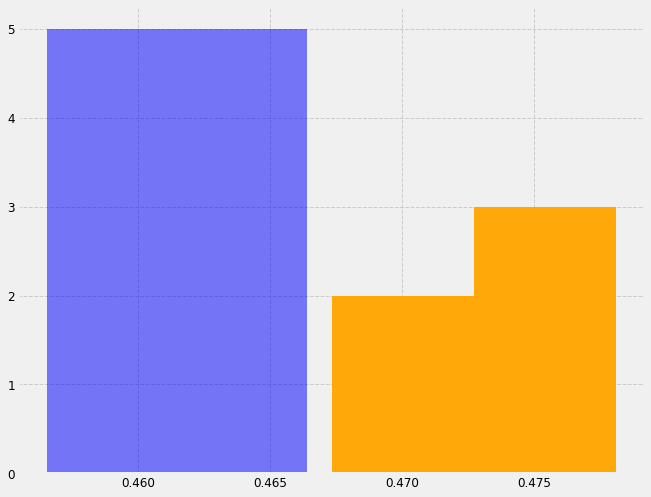

In [25]:
fig = plt.figure()
x1, x2 = x[2][0:5], y[2][0:5]
x1num_bins = int((max(x1) - min(x1)) / 0.005)
x2num_bins = int((max(x2) - min(x2)) / 0.005)
plt.hist(x1, alpha = 0.3, bins = x1num_bins, facecolor='blue', label = 'Mu2e Field')
plt.hist(x2, alpha = 0.8, bins = x2num_bins, facecolor='orange', label = 'Graded Field')


def animate(i):
    x1, x2 = x[2][0:i+5], y[2][0:i+5]
    x1num_bins = int((max(x1) - min(x1)) / 0.005)
    x2num_bins = int((max(x2) - min(x2)) / 0.005)
    plt.hist(x1, alpha = 0.3, bins = x1num_bins, facecolor='blue', label = 'Mu2e Field')
    plt.hist(x2, alpha = 0.8, bins = x2num_bins, facecolor='orange', label = 'Graded Field')
    
ani = animation.FuncAnimation(fig, animate, interval = 1000)
plt.show()

    #fig1 = plt.figure()